### increment, 가우시안 노이즈 추가

In [7]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

# 시드 설정 - 동일한 시뮬레이션 결과를 위해 설정
# 1000_data: seed = 10
# 2000_data: seed = 20
# 10000_data: seed = 100 

np.random.seed(20)

# Set some general settings, to be used across all simulations
num_signals = 2000
fs = 2000 #sampling 주파수
n_seconds = 2 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

fpath = "../../data/synthetic_data/evaluation_data/"
Clean = np.load(fpath + 'clean_data.npy')

In [8]:
# Generate artifact
frequency = 125
period = 1 / frequency
num_waveforms = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period) +1

asymmetric_artifact = np.zeros((0, len(times)))  # (0, 4000)
artifact = np.zeros((num_signals, len(times)))  # (0, 4000)

Artifact = np.zeros((0, len(times)))  # (0, 4000)

print(num_waveforms)
print(samples_per_period)

250
17


In [9]:
# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation
for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    asymmetric_artifact = np.append(asymmetric_artifact, [osc_shape], axis=0)

print("Clean shape:", Clean.shape)  # (100, 4000)

# 음의 값이 2배가 되도록 y축 shifting
asymmetric_artifact = asymmetric_artifact * 1.75 - 0.75

start1 = int(0.2 * fs)
end1 = int(1.0 * fs)
start2 = int(1.0 * fs)
end2 = int(1.8 * fs)

# Increment
for i in range(num_signals):
    x1 = np.min(Clean[i, :]) * 8
    x2 = np.min(Clean[i, :]) * 10
    
    # 각 구간의 크기를 맞추기 위해 전체 배열을 초기화
    intrement_artifact = np.zeros_like(Clean[i, :])
    
    # 구간별로 배열을 채움
    intrement_artifact[:start1] = asymmetric_artifact[i, :start1] * 0
    intrement_artifact[start1:end1] = asymmetric_artifact[i, start1:end1] * x1
    intrement_artifact[start2:end2] = asymmetric_artifact[i, start2:end2] * x2
    intrement_artifact[end2:] = asymmetric_artifact[i, end2:] * 0
    
    Artifact = np.append(Artifact, [intrement_artifact], axis=0)
    
print("Artifact shape:", Artifact.shape)  # (N, 4000)

Clean shape: (2000, 4000)
Artifact shape: (2000, 4000)


In [10]:
mean = 0
std = 1
gaussian_noise = np.random.normal(mean, std, Artifact.shape)

Artifact_noisy = Artifact + gaussian_noise

print(Artifact[0, 400:405])
print(gaussian_noise[0, 400:405])
print(Artifact_noisy[0, 400:405])


[ 19.84964396 -20.64053407 -37.41211496 -35.74819231 -30.85312551]
[-0.23404304 -0.25537296  0.29558637 -0.41226901 -0.47013253]
[ 19.61560092 -20.89590703 -37.11652858 -36.16046132 -31.32325805]


data_signal shape: (2000, 4000)
signal_with_artifact shape: (2000, 4000)


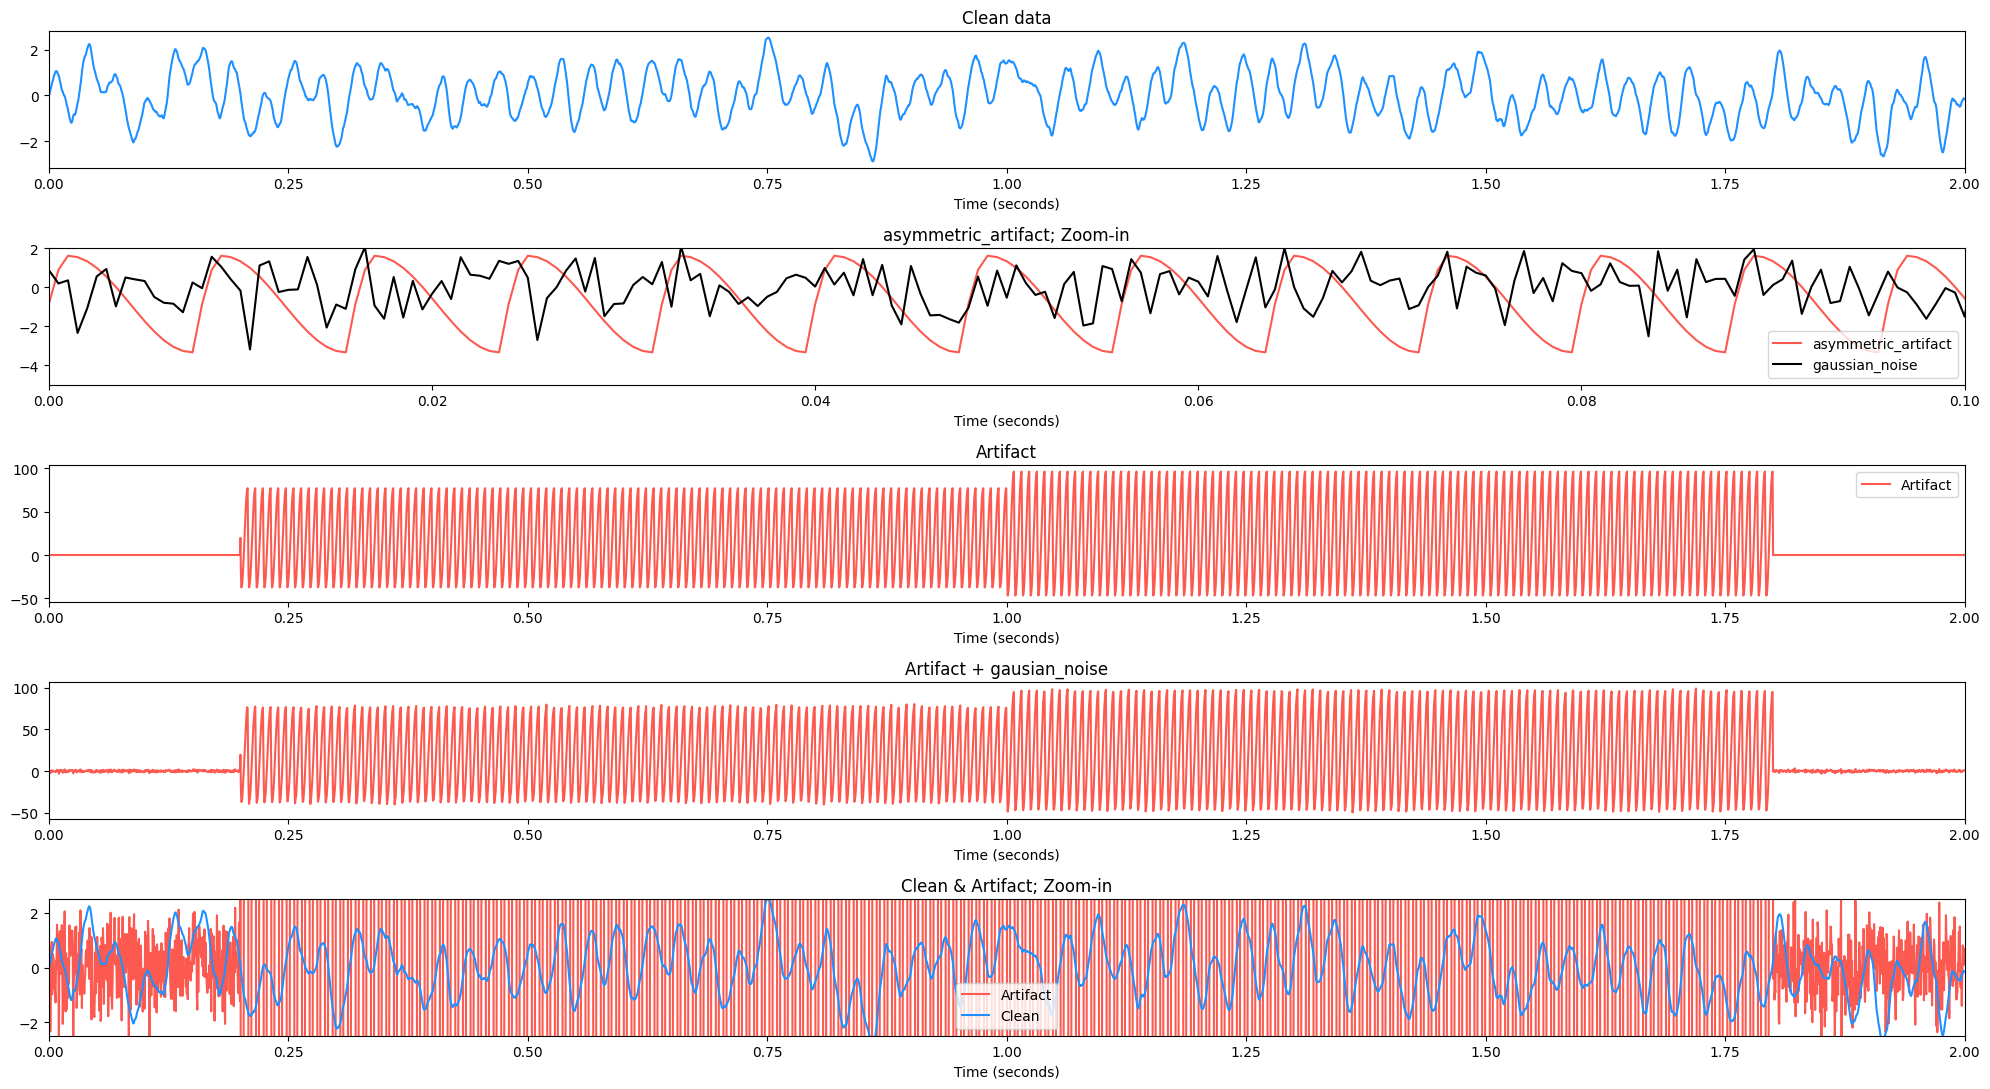

In [11]:
plt.figure(figsize=(20, 11))

num_sample = 0

plt.subplot(5, 1, 1)
plt.plot(times, Clean[num_sample, :], c='dodgerblue')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)"); plt.title('Clean data')

plt.subplot(5, 1, 2)
plt.plot(times, asymmetric_artifact[num_sample, :], c='xkcd:coral', label = 'asymmetric_artifact')
plt.plot(times, gaussian_noise[num_sample, :], c='k', label = 'gaussian_noise')
plt.xlim([0, 0.1])
plt.legend()
plt.gca().set_ylim([-5, 2])
plt.xlabel("Time (seconds)"); plt.title('asymmetric_artifact; Zoom-in')

plt.subplot(5, 1, 3)
plt.plot(times, Artifact[num_sample, :], c='xkcd:coral', label = 'Artifact')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Artifact')
plt.xlim([0, 2])

plt.subplot(5, 1, 4)
plt.plot(times, Artifact_noisy[num_sample, :], c='xkcd:coral')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)"); plt.title('Artifact + gausian_noise')

plt.subplot(5, 1, 5)
plt.plot(times, Artifact_noisy[num_sample, :], c='xkcd:coral', label = 'Artifact')
plt.plot(times, Clean[num_sample, :], c='dodgerblue', label = 'Clean')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Clean & Artifact; Zoom-in')
plt.xlim([0, 2])
plt.ylim([-2.5, 2.5])

plt.tight_layout()

print('data_signal shape:', Clean.shape)
print('signal_with_artifact shape:', Artifact.shape)


In [12]:
# -------- < 저장 > ------------------------------------------------
# -------- < data > ------------------------------------------------

np.save(fpath + "increment_artifact_data" + ".npy", Artifact)
